# Проект по банковскому скорингу

Кредитный скоринг (от англ. score «оценка»; в т.ч. гл.) — система оценки кредитоспособности (кредитных рисков) лица, основанная на численных статистических методах. Кредитный скоринг широко используется как крупными банками, микрофинансовыми организациями, так и в потребительском (магазинном) экспресс-кредитовании на небольшие суммы. Также возможно его использование в бизнесе сотовых операторов, страховых компаний и т. д. Скоринг заключается в присвоении баллов по заполнению некой анкеты, разработанной оценщиками кредитных рисков андеррайтерами. По результатам набранных баллов системой автоматически принимается решение об одобрении или отказе в выдаче кредита.

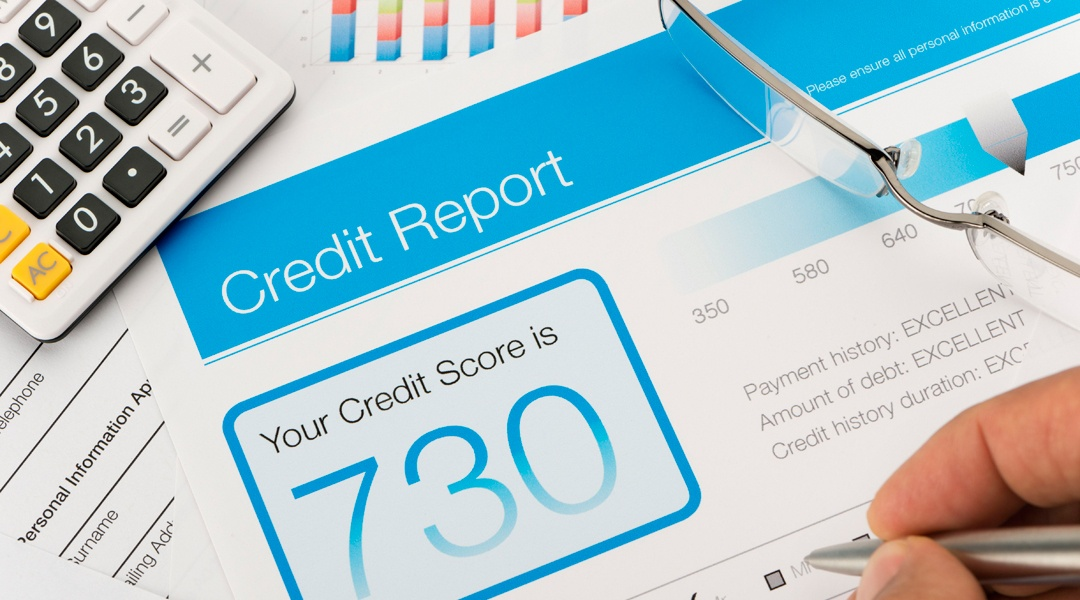

##  1 Импорт нужных библиотек

In [54]:
# импорт нужных библиотек
import pandas as pd
import numpy as np
from pandas import Series

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', 500)

## Описание признаков
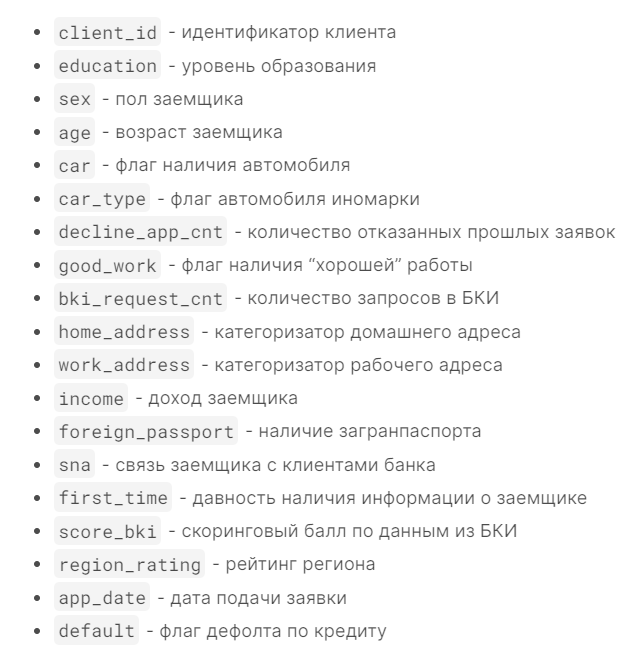

## 2 Функции

In [55]:
# Функция построения hist и boxplot для числовых признаков
def show_plot_boxplot(df, col_name, bins=10):
    """Построение гистограммы по столбцу и boxplot-а"""
    color_text = plt.get_cmap('PuBu')(0.95)
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (10, 5)
    _, axes = plt.subplots(2, 1)
    axes[0].hist(df, bins=bins)
    axes[0].set_title("Гистограмма и boxplot для признака '" +
                      col_name+"'", color=color_text, fontsize=14)
    axes[1].boxplot(df, vert=False, showmeans=True)
    axes[1].set_title('')
    return

In [56]:
# Построение ROC кривой
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label='Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.6f' %
              roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

## 3 Загрузка данных

In [57]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# добавим колонку для дф трейн
train['is_train'] = 1
test['is_train'] = 0
data = train.append(test)

In [58]:
# подрузим дополнительные данные по смертности и престпуности
# Преступность
crime = pd.read_csv('table-20.csv', sep=';')[['Age', 'Per']].rename(
    columns={'Age': 'age', 'Per': 'crime_perc'})
# crime_perc имеет тип обьект и разделитель ','
crime.crime_perc = crime.crime_perc.apply(lambda x: float(x.replace(',', '.')))
# соеденим наши дф
data = pd.merge(data, crime)

## 4 Предварительный анализ данных

In [59]:
# Посмотрим типы данных и наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [60]:
# виды колонок
# бинарные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# Катег
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
# Числовые
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'income', 'bki_request_cnt', 'crime_perc']

# дата
date_cols = ['app_date']

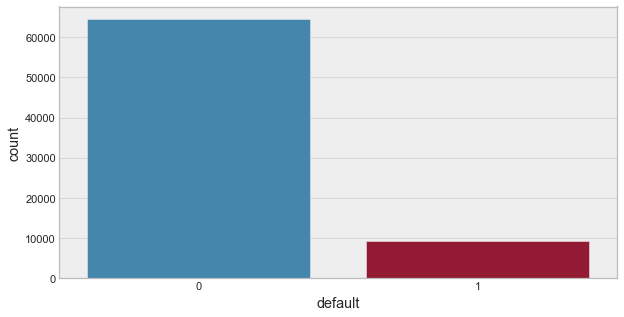

In [61]:
# Посмотрим на распределение целевой переменной
sns.countplot(train.default)

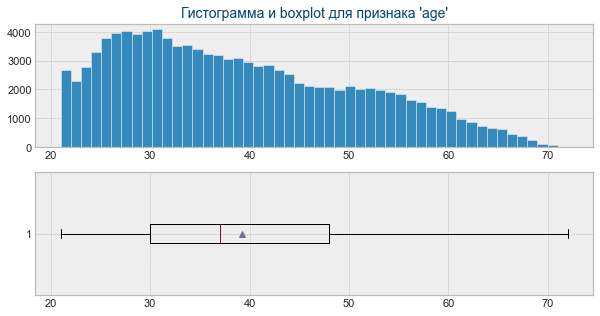

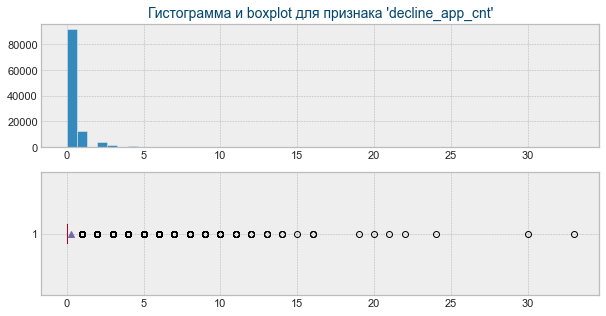

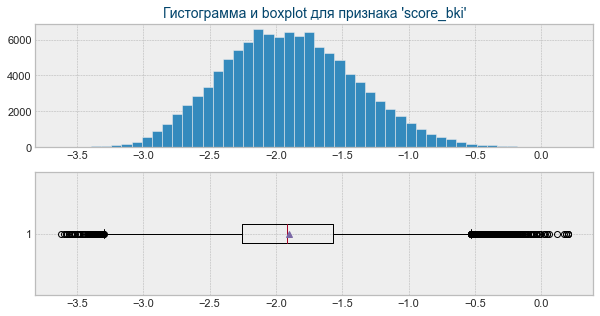

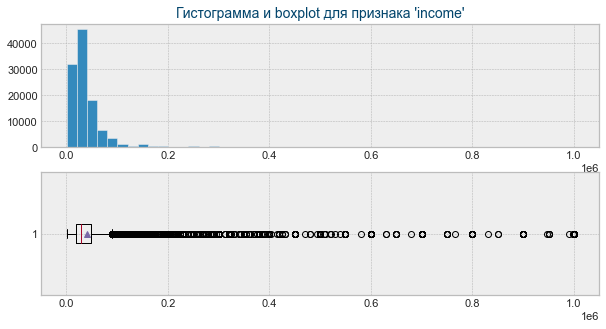

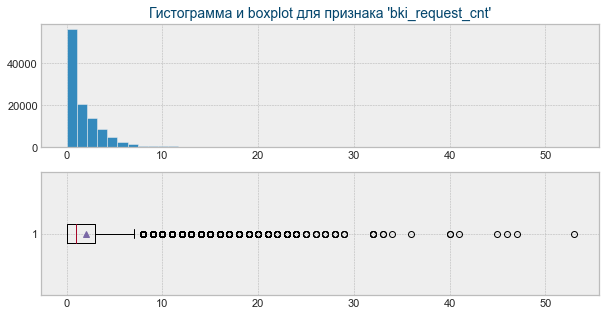

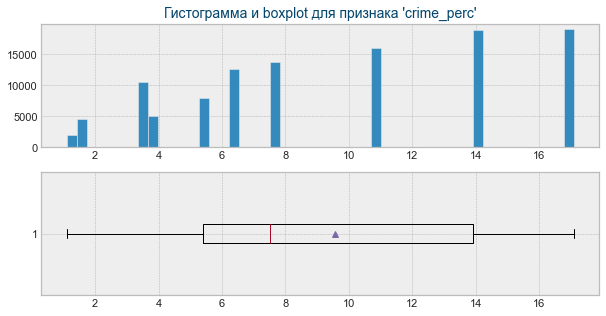

In [62]:
# Посмотрим на распределение и boxplot’ы для численных переменных
for col in num_cols:
    show_plot_boxplot(data[col], col, bins=50)

Целевая переменная распределена несбалансировано. Нужно это иметь ввиду при построении модели.  
У признаков decline_app_cnt (больше всего выбросов), score_bki,income,bki_request_cnt есть выбросы, нужно подумать что с этим можно сделать  
Признак score_bki распределен нормально, остальные нет

# Первичная обработка данных

In [63]:
# Посмотрим на признак decline_app_cnt более подробно
data['decline_app_cnt'].describe()
# Видно что 1-ый и 3-й квантии равны 0, переведем этот признак
# в бинарный где 0 это значение соответствующее 'decline_app_cnt'==0 и 1 где 'decline_app_cnt'>0

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

In [64]:
data['decline_app'] = data['decline_app_cnt'].apply(
    lambda x: 0 if x == 0 else 1)
data = data.drop(columns='decline_app_cnt')

In [65]:
# работа с датой
data['app_date'] = pd.to_datetime(data.app_date)
# работа с пропусками education. SCH является модой
data['education'] = data['education'].fillna('SCH')
# кол-во дней прошедших с самой ранней заявки
data['time_delta_days'] = (
    data['app_date']-pd.to_datetime(data.app_date).min()).apply(lambda x: x.days)
# вытаскиваем день
data['day'] = data['app_date'].dt.day
data = data.drop(columns=('app_date'))

In [66]:
# обновим наши списки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport','decline_app']
# Катег
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
# Числовые
num_cols = ['age', 'score_bki',
            'income','crime_perc','bki_request_cnt']

# дата
date_cols = ['day','time_delta_days']

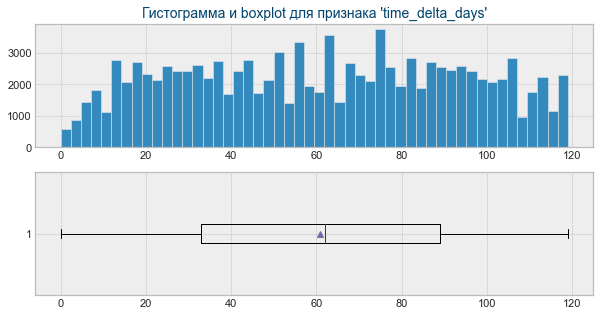

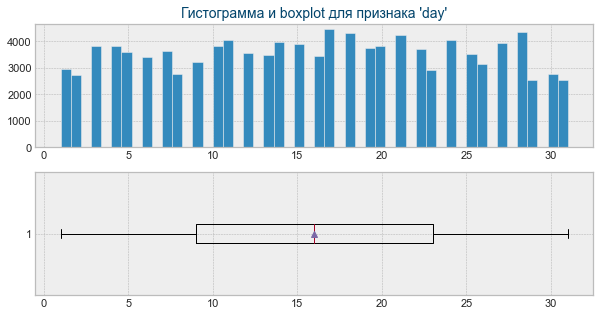

In [67]:
# Посмотрим на новые признаки связанные с датой
for i in ['time_delta_days','day']:
    show_plot_boxplot(data[i], i, bins=50)

Новые признаки не имеют выбросов, но распределены ненормально

In [68]:
# LabelEncod
label_encoder = LabelEncoder()
for column in bin_cols:
        data[column] = label_encoder.fit_transform(data[column])

### Feature Engineering

In [69]:
# Возьмем логарифм для числовых признаков с выбросами и ненормальным распределением
for column in num_cols:
    if column != 'score_bki':
        data[column] = np.log(data[column] + 1)

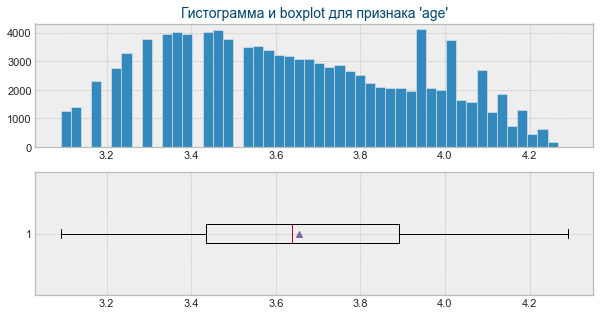

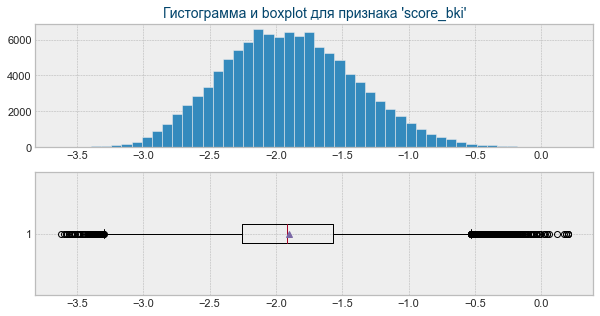

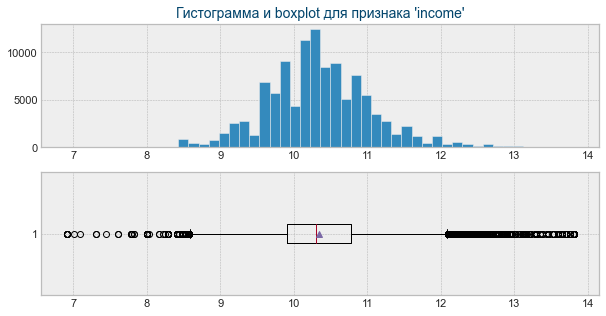

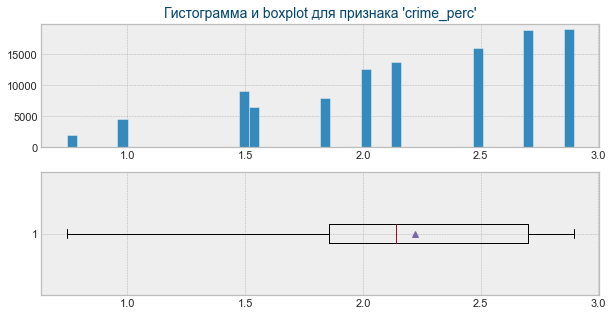

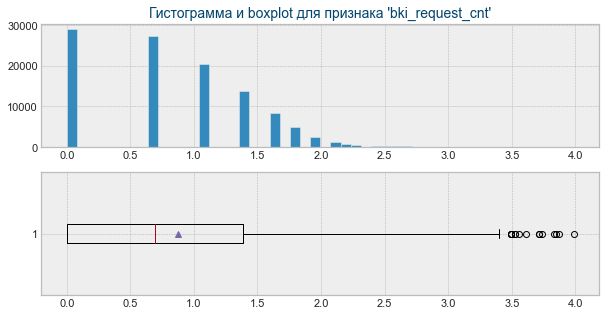

In [70]:
for col in num_cols:
    show_plot_boxplot(data[col], col, bins=50)

Видно что графики стали лучше, выбросов стало меньше  
Посмотрим на распределения категориальных признаков

# Генерация новых признаков


In [71]:
#  Сгенерируем новые признаки комбинируя категорийные и числовые признаки
data['new'] = ((data.income**2)*data.region_rating)/data.age
data['new2'] = (data.score_bki*data.region_rating)/data.age
data['new4'] = (data.age/data.first_time)*data.score_bki
data['new5'] = (data.score_bki*data.sna)
data['new6'] = (data.income**2)*data.sna
data['new7'] = ((data.income**2)*data.first_time)/data.age

In [72]:
data['score_bki_log']=np.log(abs(data['score_bki']+1))
data['new2^3']=data.new2**3

In [73]:
#обновим список
lst=['new','new2','new4','new5','new6','new7','score_bki_log','new2^3']
num_cols+=lst

# Категориальные признаки

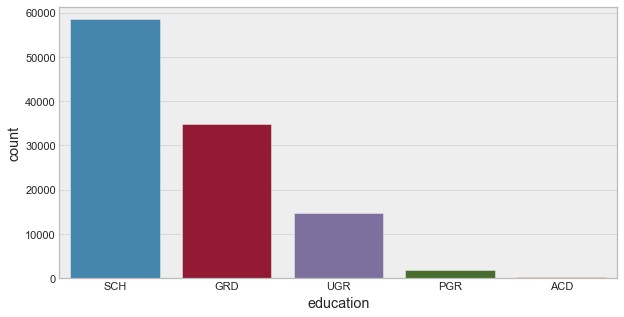

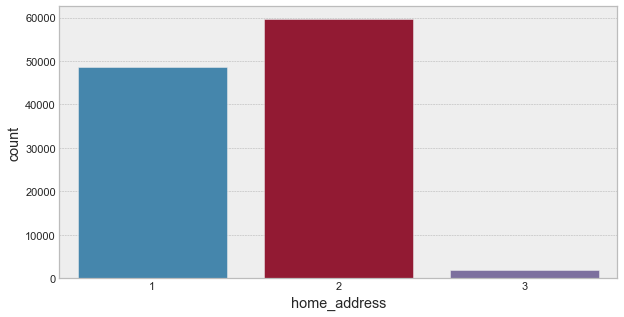

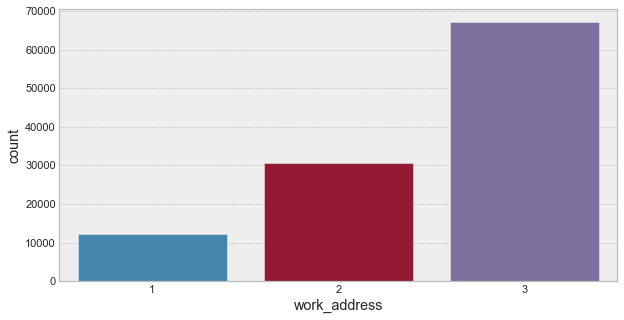

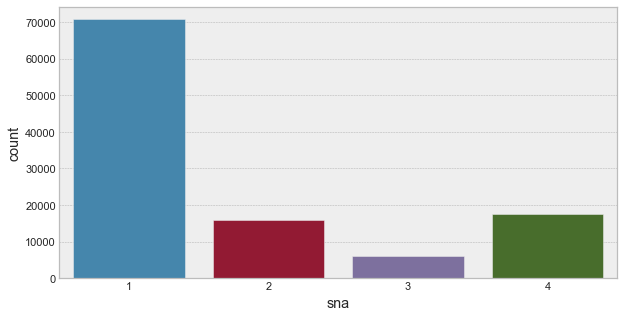

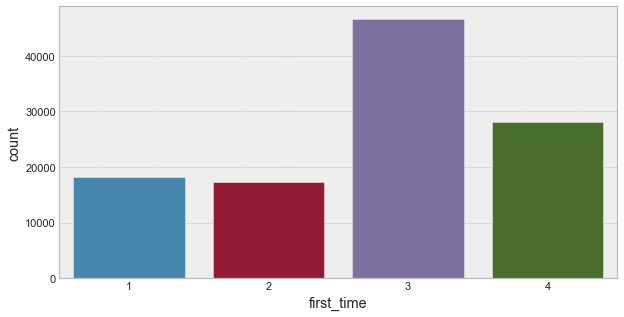

In [79]:
#посмотрим на распределения категориальных признаков
for i in cat_cols:
    plt.figure()
    sns.countplot(x=data[i])

In [80]:
# OneHot
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

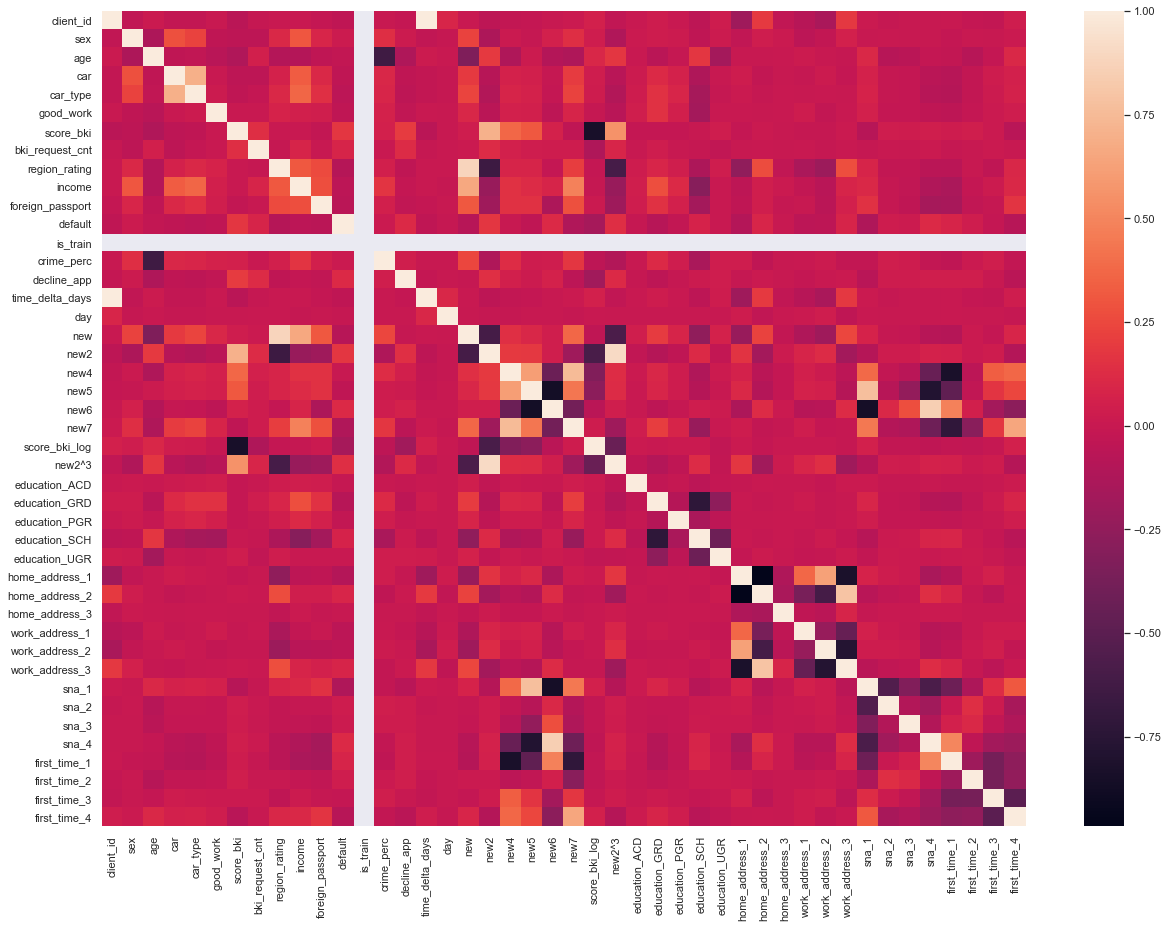

In [81]:
sns.set(rc={'figure.figsize':(20.7,15)})

sns.heatmap(data[data.is_train==1].corr())

Сколько я не старался убирать коррелирующие признаки, метрики модели не улучшаются

In [85]:
# Приступим к обучению модели, сначала отделим наш тренировочный сет
train = data.copy()
train = train[train['is_train'] == 1].drop(columns='is_train')

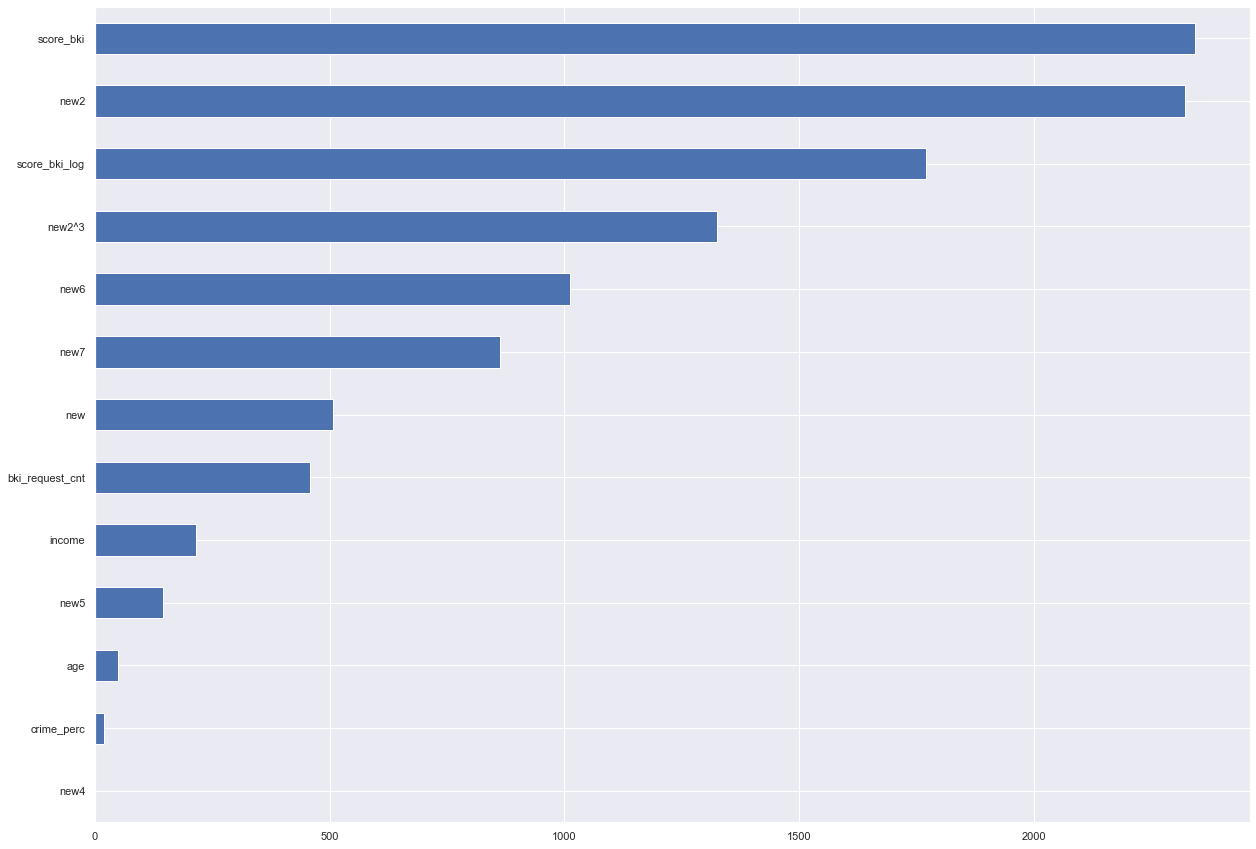

In [86]:
# Посмотрим на важность признаков
imp_num = Series(f_classif(train[num_cols], train['default'])[
                 0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [89]:
X=train.drop(columns=['default'])
Y=train.default

In [90]:
# Делим тренировочный DF на обучающий и валидационный
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

In [91]:
# Отмасштабируем данные
# MinMaxScaler лучше себя показал для данной модели
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

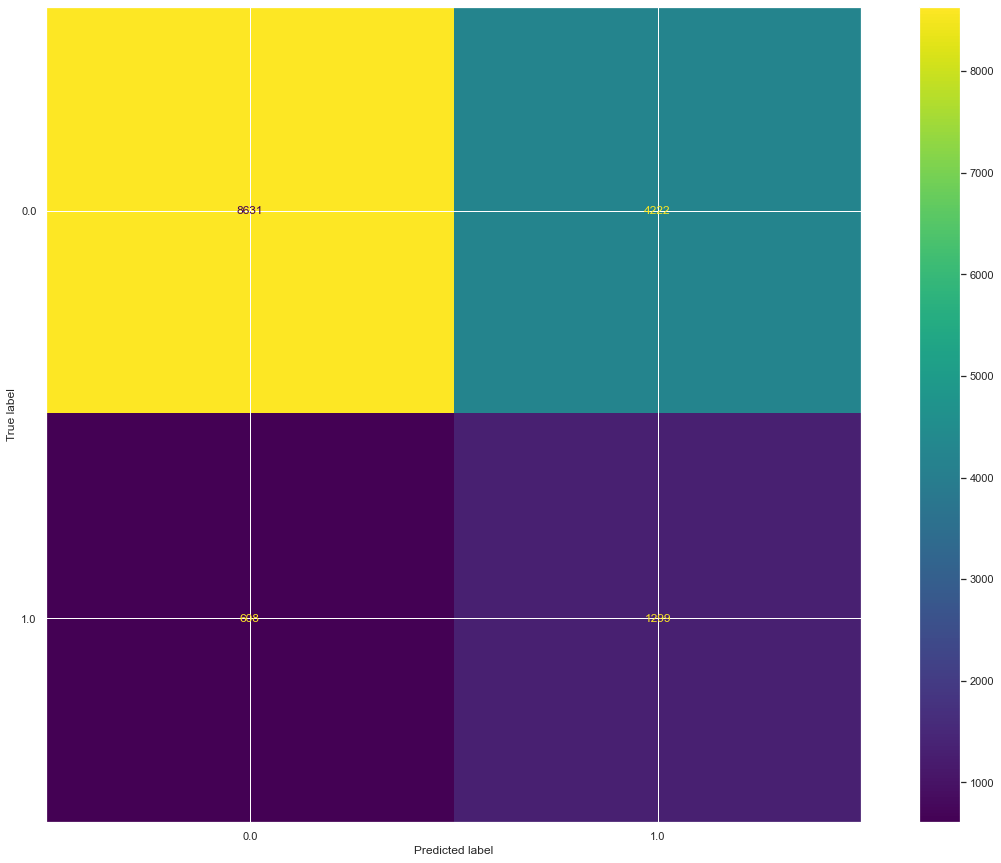

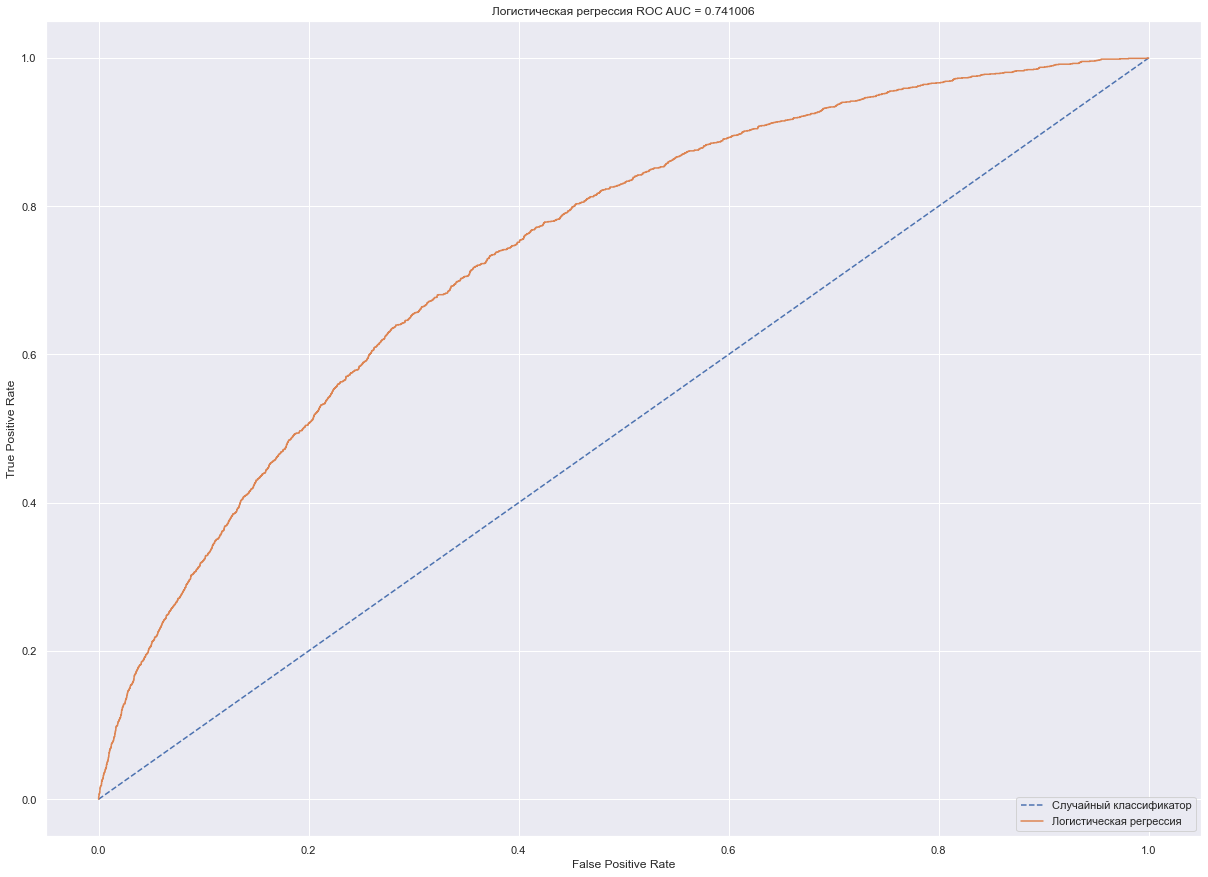

In [92]:
#Наша модель
#Randomseed фиксируем
RANDOM_SEED=42
#Создаем список параметров регулиризации для более гладкой регрессии
parameters = {'C': list(np.linspace(0,1, num=10))}
#Создаем модель
model = LogisticRegression(class_weight="balanced", max_iter=800, solver='sag', random_state=RANDOM_SEED)
#Cоздаем сетку для нахождения оптимальных параметров модели
grid_search_cv_fr = GridSearchCV(model, parameters, n_jobs = -1)
grid_search_cv_fr.fit(X_train_sc, y_train)

bestgrid_search_cv_fr = grid_search_cv_fr.best_params_
best_rf = grid_search_cv_fr.best_estimator_
best_rf.fit(X_train_sc, y_train)

#Делаем предикт
probs = best_rf.predict_proba(X_test_sc)

y_pred_prob = probs[:, 1]
y_pred = best_rf.predict(X_test)


plot_confusion_matrix(best_rf, X_test_sc, y_test)

# Оценка качества модели
show_roc_curve(y_test, y_pred_prob)

In [108]:
#Submission
X_train = data[data['is_train']==1].drop(columns=['is_train','default'])
y_train = data[data['is_train']==1].default
X_test = data[data['is_train']==0].drop(columns=['is_train','default'])

In [109]:
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [110]:
best_rf.fit(X_train_scaler, y_train)

LogisticRegression(C=0.1111111111111111, class_weight='balanced', max_iter=800,
                   random_state=42, solver='sag')

In [117]:
y_pred_prob = best_rf.predict_proba(X_test_scaler)[:, 1]
# y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_prob

array([0.73892439, 0.3471106 , 0.48109783, ..., 0.23222778, 0.35332968,
       0.2629223 ])

In [122]:
submit=pd.DataFrame(data[data['is_train']==0][['client_id']]).reset_index().drop(columns='index')
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)
submit.head()

,client_id,default
0,13947,0.738924
1,76496,0.347111
2,21274,0.481098
3,39486,0.622151
4,35262,0.372281


In [ ]:
submit.cli